# Static force spectroscopy simulation over a viscoelastic material

In [36]:
import sys
sys.path.append('d:\github\pycroscopy')
from pycroscopy.simulation.afm_lib import sfs_genmaxwell_lr
from pycroscopy.simulation.force_spectroscopy import log_scale, nls_fit, linear_fit_Nob, log_tw, percent_error
from pycroscopy.simulation.rheology import chi_th, j_t, theta_v, compliance_maxwell, theta_g
from pycroscopy.simulation.afm_calculations import derivative_cd
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Model parameters (parameters of the Generalized Maxwell model)

In [2]:
M = 5 #number of Maxwell arms for Generalized Maxwell model

Ge = 1.0e6 #Equilibrium modulus

G = np.zeros(M)
tau = np.zeros(M)
G[0] = 9.0e8
G[1] = 5.0e6
G[2] = 3.0e7
G[3] = 2.0e6
G[4] = 1.0e5

Gg = sum(G[:]) + Ge

tau[0] = 1.0e-3
tau[1] = 1.0e-2
tau[2] = 1.0e-1
tau[3] = 1.0e0
tau[4] = 1.0e1

## Cantilever and general simulation paramters

In [3]:
k_m1 = 10.0  #first eigenmode stiffness
R = 2000.0e-9  #tip radius
alfa = 16.0*np.sqrt(R)/3.0  #cell constant (related to tip geometry)
y_dot = 100.0e-9  #approach speed
y_t_initial = 1.0e-10  #initial position of cantilever with respect to the sample

#1st, 2nd and 3rd eigenmode quality factors
Q1 = 100.0
Q2 = 200.0
Q3 = 300.0

fo1 = 1.0e4  #first eigenmode resonance frequency
period1 = 1.0/fo1  #fundamental period
dt = period1/10.0e3  #simulation timestep
simultime = y_t_initial/y_dot + 1.0  #total simulation time
printstep = 1.0e-5 #how often will the result be stored in the arrays (this should be larger than dt)

## Main portion of the static force spectroscopy simulation

In [4]:
print('This cell may take a while to compute, it is performing the simulation')
jit_sfs = jit()(sfs_genmaxwell_lr)  #accelerating the simulation with numba
%time t, tip, Fts, xb, defl, zs = jit_sfs(G, tau, R, dt, simultime, y_dot, y_t_initial, k_m1, fo1, Ge, Q1, printstep)

This cell may take a while to compute, it is performing the simulation
Wall time: 56.4 s


## Performing theoretical convolution

$h(t)^{3/2} = \frac{3}{16 \sqrt{R}} \int_0^t J(t-\zeta) \frac{dF(\zeta)}{d\zeta} d\zeta$

To make the convolution we first have to calculate the compliance of our viscoelastic model, then we can get the time derivative of the tip-sample for trace and convolve these quantities.

In [5]:
#obtaining the compliance of the generalized Maxwell model
jit_compliance = jit()(compliance_maxwell)
t_r, J_r = jit_compliance(G, tau, Ge, t[2]-t[1], t[len(t)-1]-t[0])

In [6]:
#performing the time derivative of force that will be convolved with the cree compliance
df_dt = derivative_cd(Fts, t-t[0])

In [7]:
#numerical convolution of the creep compliance with the time derivative of force as in the above equation
conv = np.convolve(J_r, df_dt[0:len(df_dt)-2], mode='full')*(t[2]-t[1])
conv = conv[range(len(J_r))]

## Comparing the simulation results with the theoretical convolution

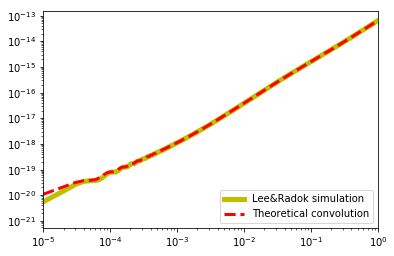

In [8]:
plt.plot(t -t[0], 16.0/3.0*np.sqrt(R)*(-tip)**(3.0/2), 'y', lw=5, label = 'Lee&Radok simulation')  #Lee Radok
plt.plot(t_r -t_r[0], conv, 'r--', lw=3, label = 'Theoretical convolution')

plt.xscale('log')
plt.yscale('log')
plt.xlim(printstep, simultime)
plt.legend(loc=4)

## Performing non-linear square optimization to retrieve properties

In [31]:
t_res = 1.0e-4   #time resolution (inverse of sampling frequency)
t_exp = 1.0  #total experimental time

tip_log, t_log_sim = log_scale(tip, t-t[0], t_res, t_exp) #Weighting time and tip arrays in logarithmic scale
F_log, _ = log_scale(Fts, t -t[0], t_res, t_exp) #Weighting force array in logarithmic scale
Fdot = linear_fit_Nob(t_log_sim, F_log)    #Getting linear slope of force in time trace
chi_simul = alfa*pow(-tip_log,1.5)/Fdot     #according to eq 19, relation between chi and tip when force is assumed to be linear

In [40]:
method = 0  #the load is assumed to be linear in time
arms = 4  #number of Maxwell arms in the model
Jg_c, tau_c, J_c = nls_fit(t-t[0], -tip, Fts, R, t_res, t_exp, arms, method, 2.0e-10, 5.0e-8, 1.0e-3, 1.0e-7, 1.0e-2, 1.0e-6, 1.0e-1, 1.0e-6, 1.0e0)


In [41]:
# defining time and frequency axes for plots
t_log = log_tw(1.0e-4, 1.0)
omega = log_tw(1.0e-1, 1.0e5, 20)

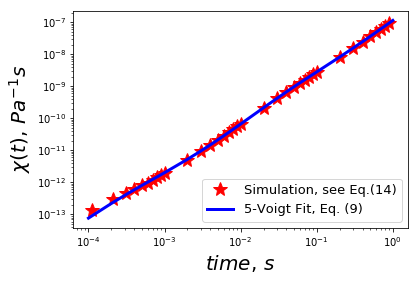

In [42]:
#chi_theor = chi_th(t_th, Jg_v, J_v, tau_v)
chi_5 = chi_th(t_log, Jg_c, J_c, tau_c)
plt.plot(t_log_sim, chi_simul, 'r*', markersize=15, label=r'Simulation, see Eq.(14)')
plt.plot(t_log, chi_5, 'b', lw = 3.0, label=r'5-Voigt Fit, Eq. (9)')
plt.legend(loc=4, fontsize=13)
plt.xlabel(r'$time, \,s$', fontsize='20',fontweight='bold')
plt.ylabel(r'$\chi(t), \,Pa^{-1}s$',fontsize='20',fontweight='bold')
plt.xscale('log')
plt.yscale('log')

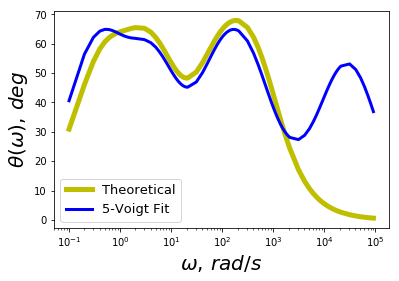

In [43]:
theta_th = theta_g(omega, G, tau, Ge)
theta_5 = theta_v(omega, Jg_c, J_c, tau_c)
plt.plot(omega, theta_th, 'y', lw = 5.0, label=r'Theoretical')
plt.plot(omega, theta_5, 'b', lw = 3.0, label=r'Fit, linear assumption')
plt.legend(loc='best', fontsize=13)
plt.xlabel(r'$\omega, \,rad/s$', fontsize='20',fontweight='bold')
plt.ylabel(r'$\theta(\omega),\,deg$',fontsize='20',fontweight='bold')
plt.xscale('log')

### Without linear load assumption

In [45]:
method = 1  #the load is assumed to be linear in time
arms = 4  #number of Maxwell arms in the model
Jg_nl, tau_nl, J_nl = nls_fit(t-t[0], -tip, Fts, R, t_res, t_exp, arms, method, 2.0e-10, 5.0e-8, 1.0e-3, 1.0e-7, 1.0e-2, 1.0e-6, 1.0e-1, 1.0e-6, 1.0e0)


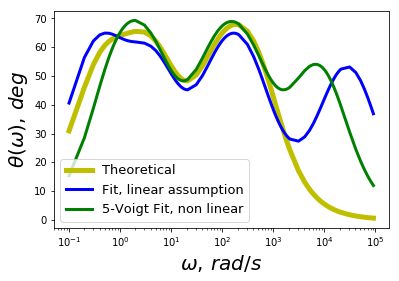

In [48]:
theta_th = theta_g(omega, G, tau, Ge)
theta_5 = theta_v(omega, Jg_c, J_c, tau_c)
plt.plot(omega, theta_th, 'y', lw = 5.0, label=r'Theoretical')
plt.plot(omega, theta_5, 'b', lw = 3.0, label=r'Fit, linear assumption')
theta_5nl = theta_v(omega, Jg_nl, J_nl, tau_nl)
plt.plot(omega, theta_5nl, 'g', lw = 3.0, label=r'5-Voigt Fit, non linear')
plt.legend(loc='best', fontsize=13)
plt.xlabel(r'$\omega, \,rad/s$', fontsize='20',fontweight='bold')
plt.ylabel(r'$\theta(\omega),\,deg$',fontsize='20',fontweight='bold')
plt.xscale('log')